# Subplot for the figure on single-cell dynamics
The figure should include 
- typical action potentials observed in cardiomyocites and neurons modelled by the Hodgkin-Huxley model with appropriate parameters.
- simplified, low-dimensional model (FH) with the corresponding phase space underlying action potential dyanamics

In [2]:
using Pkg
Pkg.activate("../")
using DynamicalSystems
using CairoMakie

  Activating project at `~/git/projects/perspective_heart_and_brain`


In [12]:
# rewrite this as one line

α_h(-30)


0

In [13]:
Dt = 1e-3 # ms
# implement Ten-Tusscher model that is of Hodgkin-Huxley type
# Reference for equations and parameters:
# Ten Tusscher, K. H. W. J., Noble, D., Noble, P. J., & Panfilov, A. V. (2004). A model for human ventricular tissue.
function ten_tuscher(; 
    return_gating_functions=false
    )
    # static parameters
    #membrane properties
    C_m = 2 # μF/cm²
    R = 8.314 # J/(mol*K)
    T = 310 # K
    F = 96.4867 # C/mmol
    # Na current
    G_Na = 14.838 # nS/pF
    Na_o = 140 # mM
    # Ca2+ current
    G_CaL = 1.75e-4 # cm^3/s/μF
    Ca_o = 2 # mM
    
    # K channel
    G_K1 = 5.405 # nS/pF
    K_o = 5.4 # mM

    # Fast Na+ current (28-39)
    m_∞(V) = 1 / (1 + exp((-56.86 - V)/9.03))^2
    α_m(V) = 1 / (1 + exp((-60 - V)/5))
    β_m(V) = 0.1 / (1 + exp((V + 35)/5)) + 0.1 / (1 + exp((V - 50)/200))
    τ_m(V) = α_m(V) * β_m(V)
    h_∞(V) = 1 / (1 + exp((V + 71.55)/7.43))^2
    α_h(V) = V < -40 ? 0.057 * exp(-(V + 80)/6) : 0
    β_h(V) = V < -40 ? 2.7 * exp(0.079 * V) + 3.1e5 * exp(0.3485 * V) : 0.77 / (0.13 * (1 + exp(-(V + 10.66)/11.1)))
    τ_h(V) = 1 / (α_h(V) + β_h(V))
    j_∞(V) = 1 / (1 + exp((V + 71.55)/7.43))^2
    α_j(V) = V < -40 ? (-25428 * exp(0.2444 * V) - 6.948e-6 * exp(-0.04391 * V)) * (V + 37.78) / (1 + exp(0.311 * (V + 79.23))) : 0
    β_j(V) = V < -40 ? 0.02424 * exp(-0.01052 * V) / (1 + exp(-0.1378 * (V + 40.14))) : 0.6 * exp(0.057 * V) / (1 + exp(-0.1 * (V + 32)))
    τ_j(V) = 1 / (α_j(V) + β_j(V))

    # L-type Ca2+ current (40-54)
    d_∞(V) = 1 / (1 + exp((-5-V)/7.5))
    α_d(V) = 1.4/(1 + exp((-35-V)/13)) + 0.25  
    β_d(V) = 1.4/(1 + exp((V+5)/5))
    γ_d(V) = 1/(1 + exp((50-V)/20))
    τ_d(V) = α_d(V) * β_d(V) + γ_d(V)
    f_∞(V) = 1 / (1 + exp((V + 20)/7))
    τ_f(V) = 1125 * exp(-((V + 27)^2)/240) + 165 / (1 + exp((25 - V)/10)) + 80
    α_f_Ca(Ca_i) = 1 / (1 + (Ca_i/0.000325)^8)
    β_f_Ca(Ca_i) = 0.1 / (1 + exp((Ca_i - 0.0005)/0.0001))
    γ_f_Ca(Ca_i) = 0.2 / (1 + exp((Ca_i - 0.00075)/0.0008))
    f_Ca_∞(Ca_i) = (α_f_Ca(Ca_i) + β_f_Ca(Ca_i) + γ_f_Ca(Ca_i) + 0.23) / 1.46
    τ_f_Ca = 2 # ms

    # transient outward currents (55-61), focus on epicardial cells
    r_∞(V) = 1 / (1 + exp((20-V)/6))
    τ_r(V) = 9.5 * exp((-(V+40)^2)/1800) + 0.8
    s_∞(V) = 1 / (1 + exp((V + 20)/5))
    τ_s(V) = 85 * exp((-(V+45)^2)/320) + 5 / (1 + exp((V - 20)/5)) + 3

    # slow delayed rectifier K+ current (62-66)
    Xs_∞(V) = 1 / (1 + exp((-5-V)/14))
    
    function f!(u, p, t)
        # u = [V, X_i, z_i]
        V = u[1]
        I_stim, = p

        # membrane currents [I_ion] = μA/cm²
        # standard units: nS/pF * mV = 1e-9 (A/V) * 1e12 (V/As) * 1e-3 V = V/s

        # reversal potentials (25-26)
        # [E_x] = [R][T]/[F] = J/mol/K*K/C*mmol = mJ/C = m Ws/C = mW/A = mV
        Na_i, K_i, Ca_i = u[2:4]
        E_Na = R*T/(z*F) * log(Na_o/Na_i) 
        E_K  = R*T/(z*F) * log(K_o/K_i) 
        E_Ca = R*T/(z*F) * log(Ca_o/Ca_i)
        E_Ks = R*T/(F) * log((K_o + p_KNa*Na_o)/(K_i + p_KNa*Na_i))

        # Na current (4)
        m,h,j = u[5:7]
        I_Na = G_Na * m^3 * h * j * (V - E_Na)
        du[5] = (m_∞(V) - m) / τ_m(V) 
        du[6] = (h_∞(V) - h) / τ_h(V) 
        du[7] = (j_∞(V) - j) / τ_j(V)

        # L-type Ca2+ current (5)
        d,f,f_Ca = u[8:10]
        I_CaL = G_CaL * d * f * f_Ca * 4 * V*F^2/(R*T) * (Ca_i * exp(2*V*F/(R*T)) - 0.341*Ca_o) / (exp(2*V*F/(R*T)) - 1)
        du[8] = (d_∞(V) - d) / τ_d(V)
        du[9] = (f_∞(V) - f) / τ_f(V)
        du[10] = (f_Ca_∞(Ca_i) - f_Ca) / τ_f_Ca
        if f_Ca_∞(Ca_i) > f_Ca and V > -60 
            du[10] = 0 # implements the k=0 case in the paper
        end

        # Transient outward current (6) for epicardial cells (relevant for s)
        r,s = u[11:12]
        I_to = G_to * r * s * (V - E_K)
        du[11] = (r_∞(V) - r) / τ_r(V)
        du[12] = (s_∞(V) - s) / τ_s(V)

        # Slow delayed rectifier currents (7)
        I_Ks = G_Ks * Xs^2 * (V - E_Ks)

        # Rapid delayed rectifier current (8)
        I_Kr = G_Kr * sqrt(K_o/5.4) * Xr1 * Xr2 * (V - E_K)

        # Inward rectifier K+ current (9)
        I_K1 = G_K1 * sqrt(K_o/5.4) * X_K1∞(V) * (V - E_K)

        # Na+/Ca2+ exchanger (10)
        α=2.5
        I_NaCa = k_NaCa * (exp(gamma*V*F/(R*T)) * Na_i^3 * Ca_o - exp((gamma-1)*V*F/(R*T)) * Na_o^3 * Ca_i * α) / (K_mNa^3 + Na_o^3) / (K_mCa + Ca_o) / (1 + k_sat * exp((gamma-1)*V*F/(R*T)))

        # Na+/K+ pump (11)
        I_NaK = R_NaK * K_o * Na_i / (K_o + K_mK) / (Na_i + K_mNa)/(1 + 0.1245 * exp(-0.1*V*F/(R*T)) + 0.0365 * exp(-V*F/(R*T)))

        # Ca2+ pump (12)
        I_pCa = G_pCa * Ca_i / (K_pCa + Ca_i)

        # K+ pump (13)
        I_pK = G_pK * (V - E_K)/(1 + exp((25-V)/5.98))

        # background currents (14-15)
        I_bNa = G_bNa * (V - E_Na)
        I_bCa = G_bCa * (V - E_Ca)

        # intracellular dynamics (16-22)
        I_leak = V_leak * (Ca_sr - Ca_i)
        I_up = V_maxup / (1 + (K_up^2 / Ca_i^2))
        I_rel = (a_rel * Ca_sr^2 / (b_rel^2 + Ca_sr^2) + c_rel) * dg


        
        # sum all together
        I_ion = I_Na + I_CaL

        # change membrane potential [dV] = mV/ms
        # [dV] = (μA/cm²) / (μF/cm²) = mV/ms
        dV = - (I_ion - I_stim) / C_m
        du[1] = dV

        # in-place update of du 
        return nothing
    end

    # initial conditions (TODO)

    return f!, u0
end

ten_tuscher (generic function with 1 method)

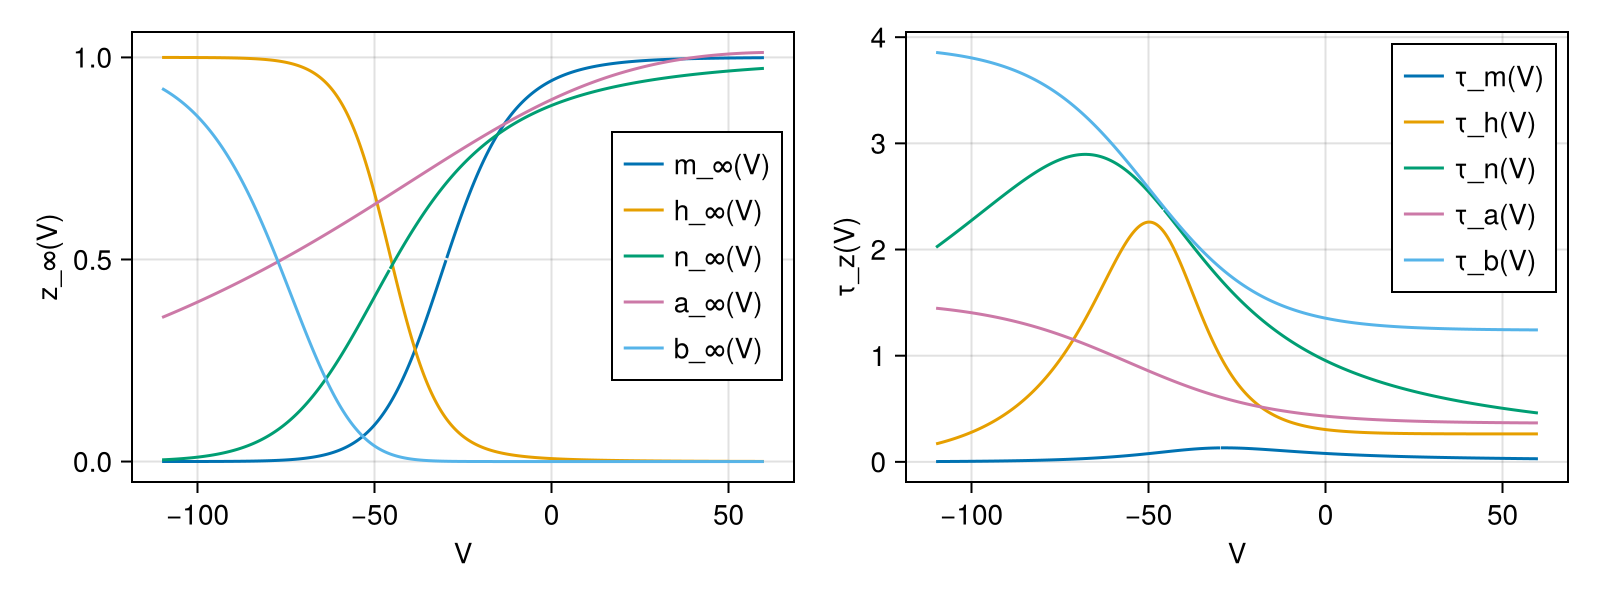

In [3]:
# get gating function from model
f, z_∞, τ_z = ten_tusscher(return_gating_functions=true)

# plot inf values as function of V
V = -110:0.1:60
fig = Figure(size=(800,300))
ax = Axis(fig[1, 1], xlabel="V", ylabel="z_∞(V)")
z_labels = ["m", "h", "n", "a", "b"]
for (i,z) in enumerate(z_∞)
    lines!(ax, V, z.(V), label="$(z_labels[i])_∞(V)")
end
axislegend(ax, merge=true, unique=true, position=:rc)
# same for τ values in a second plot
ax = Axis(fig[1, 2], xlabel="V", ylabel="τ_z(V)")
for (i,τ) in enumerate(τ_z)
    lines!(ax, V, τ.(V), label="τ_$(z_labels[i])(V)")
end
axislegend(ax, merge=true, unique=true)
fig

[-47.602308205874884, 0.11158752106588095, 0.7208129403593665, 0.3944803262859199, 0.6318639281947367, 0.07031527656474955]

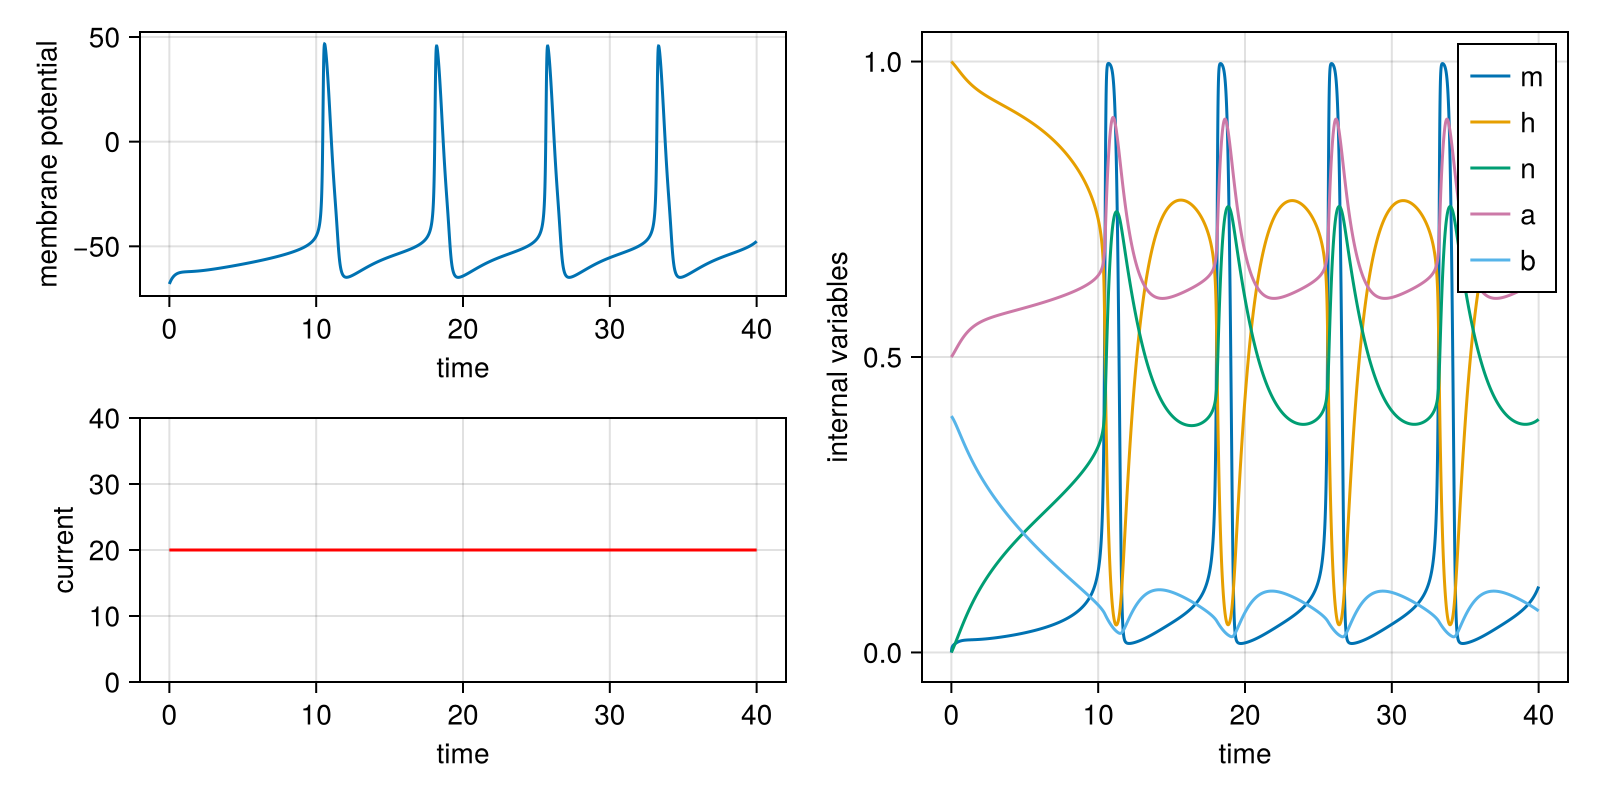

In [4]:
# Benchmark for zero current
u0 = [-68, 0, 1, 0, 0.5, 0.4]
I_static(t) = 20. # 
p0 = [I_static]
system = CoupledODEs(connor_stevens(), u0, p0)
total_time = 40 #ms
Y, t = trajectory(system, total_time; Dt=Dt)

# get last value
Y_equil = Y[end]
print(Y_equil)

# figure
fig = Figure(size=(800, 400))
ax = Axis(fig[1, 1]; xlabel="time", ylabel="membrane potential")
var = Y[:, 1]
I_t = [I_static(t_) for t_ in t]
lines!(ax, t, var)
# current
ax = Axis(fig[2, 1]; xlabel="time", ylabel="current")
lines!(ax, t, I_t, color=:red)
# internal variables
ax = Axis(fig[:, 2]; xlabel="time", ylabel="internal variables")
lines!(ax, t, Y[:, 2], label="m")
lines!(ax, t, Y[:, 3], label="h")
lines!(ax, t, Y[:, 4], label="n")
lines!(ax, t, Y[:, 5], label="a")
lines!(ax, t, Y[:, 6], label="b")
axislegend(ax, merge=true, unique=true)
fig


In [ ]:
# define time-dependent input current as a zero current with a stong constant current pulse in the interval [1,2]ms 
function I_stim(t)
    if 5 < t <= 6
        return 50
    elseif 11 < t <= 12
        return 70
    else
        return 0.0
    end
end
# equilibrium values from simulation with zero current
u0 = [-67.97750560300683, 0.01007017811593413, 0.965910414853597, 0.1558661552963623, 0.5404265695664189, 0.28864530036215374]
p0 = [I_stim]
system = CoupledODEs(connor_stevens(), u0, p0)
total_time = 400 #ms
Y, t = trajectory(system, total_time; Dt = Dt)

(6-dimensional StateSpaceSet{Float64} with 400001 points, 0.0:0.001:400.0)

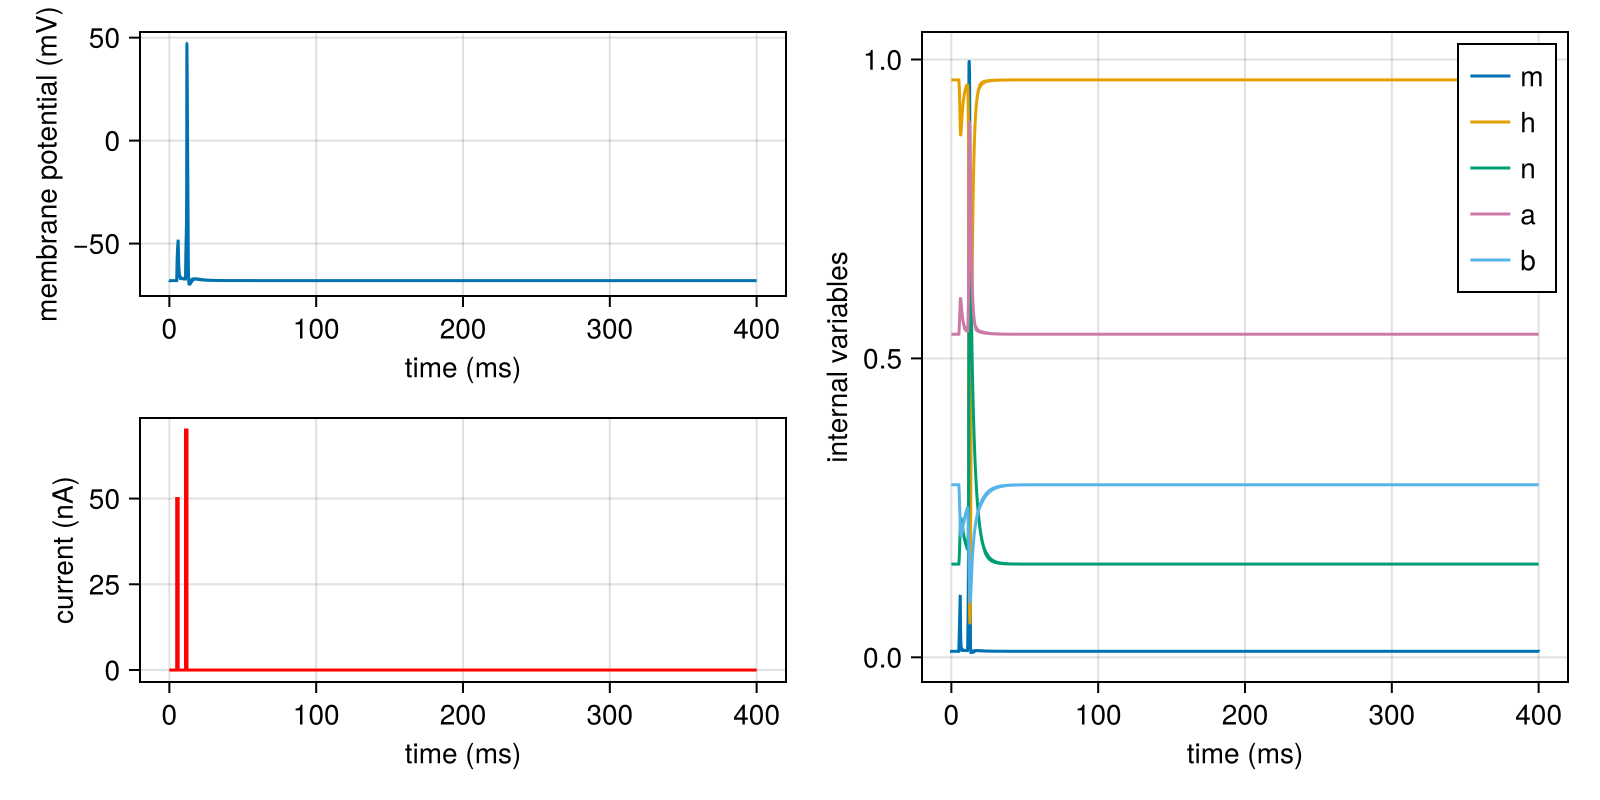

In [ ]:
# plot with Makie of time series of membrane potential
# Top: membrane potential
# Bottom: input current
fig = Figure(size = (800, 400))
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "membrane potential (mV)")
var = Y[:,1]
I_t = [I_stim(t_) for t_ in t]
lines!(ax, t, var)
# current
ax = Axis(fig[2, 1]; xlabel = "time (ms)", ylabel = "current (nA)")
lines!(ax, t, I_t, color = :red)
# internal variables
ax = Axis(fig[:, 2]; xlabel = "time (ms)", ylabel = "internal variables")
lines!(ax, t, Y[:,2], label = "m")
lines!(ax, t, Y[:,3], label = "h")
lines!(ax, t, Y[:,4], label = "n")
lines!(ax, t, Y[:,5], label = "a")
lines!(ax, t, Y[:,6], label = "b")
axislegend(ax, merge = true, unique = true)
fig